<h1>Baseline with ResNet50</h1>

* Features: 15-second mel spectrograms, augmented with pitch shift and pink noise
* Architecture: ResNet50
* Model: Fine-tuning of IMAGENET1K_V2 weights
* Loss function: Soft Labeling Loss
* Target: ~250 musicmap genres

In [1]:
# Imports
import os

from PIL import Image

import torch
import torchvision
import torchvision.models as models
from torchvision import transforms
from torch import nn, optim
import torch.nn.functional as F
import torchvision.transforms.functional as Fvision
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
from torch.nn.functional import one_hot

import pandas as pd
import networkx as nx
from bs4 import BeautifulSoup
from collections import defaultdict
from pyvis.network import Network
import json
from tabulate import tabulate
from collections import Counter
import tqdm

Set the working directory

In [2]:
working_directory = '/Volumes/Sonnet_SSD/DocumentsS/GitHub/neuromatch_spectrograms/'

<h1>Shortest Path Matrix</h1>

One of our evaluation metrics will be the average shortest path. To compute this, we'll need to generate a shortest path matrix from the musicmap graph.

Since this process involves a lot of code that we'll be reusing with various models, I've saved the code as a separate, importable file.

In [3]:
from musicmap_graph_creator import create_musicmap_graph, compute_shortest_paths_between_classes_nx

musicmap_graph = create_musicmap_graph(
    primary_edge_weight = 1, 
    secondary_edge_weight = 2,
    backlash_edge_weight = 3,
    supergenre_edge_weight = 4,
    world_supergenre_weight = 1,
    world_cluster_weight = 1,
    util_genre_weight = 2,
    cluster_weight = 1
)

shortest_graph, class_names = compute_shortest_paths_between_classes_nx(
    class_dir="30_second_features/musicmap_processed_output/resnet_mel_rgb/",  # path to folder with class folders
    graph=musicmap_graph,
    return_tensor=True
)

<h2>Computing Means and SDs</h2>

The current code is meant to be used with a pre-trained resnet model. However, once we start training a model with our own data, we'll need to compute means and standard deviations for each channel. The code below will let us do that

In [ ]:
# For each image in the subfolders of the images_original directory, stack the images in a tensor
def stack_images_from_subfolders(base_directory):
    image_tensors = []
    for subdir, _, files in os.walk(base_directory):
        for file in files:
            if file.endswith('.png'):
                file_path = os.path.join(subdir, file)
                image_pil = Image.open(file_path)
                image_tensor = transforms.ToTensor()(image_pil)
                image_tensor = remove_alpha_channel(image_tensor)
                image_tensors.append(image_tensor)
    return torch.stack(image_tensors)

# Stack images from the subfolders of 30_second_features/musicmap_processed_output_splits_train/resnet_mel_rgb inside the working directory
image_tensor_stack = stack_images_from_subfolders(os.path.join(working_directory, '30_second_features/musicmap_processed_output_splits_train/resnet_mel_rgb/'))

# Show the size of stacked_images_tensor
print(f"Stacked images tensor shape: {image_tensor_stack.shape}")

# Assuming the tensor is shaped like [N_images, N_channels, Height, Width] we can compute the mean for each of the four channels:
means = image_tensor_stack.mean(dim=(0, 2, 3)) #This tells PyTorch to average over dimensions 0, 2, and 3
sds = image_tensor_stack.std(dim=(0, 2, 3))

# Convert the tensors to tuples for compatibility with Normalize
means = tuple(means.tolist())
sds = tuple(sds.tolist())

print('means are:', means)
print('standard deviations are:', sds)

Stacking the images takes about 40 seconds; to avoid this, we'll also have an option to "manually" input the means and standard deviations that were computed previously using the code below

In [ ]:
# We can manually input the mean and SD values from a previous computation:
means = [0.2674176096916199, 0.12778985500335693, 0.42408671975135803]
sds = [0.03101411648094654, 0.13033869862556458, 0.07192454487085342]

<h2>Setting Up a Transformer</h2>

Our png files have an alpha channel, which we'll need to remove to use them with ResNet. Note that ImageFolder convergs RGBA files into RGB (see https://discuss.pytorch.org/t/handling-rgba-images/88428), so we don't need to worry about the alpha channel? Including the helper function here just in case we need it.

We'll also need to identify the means and standard deviations for each channel. ResNet was trained on ImageNet, so we'll need to use those values.

In [4]:
def remove_alpha_channel(image_tensor):
    if image_tensor.shape[0] == 4:  # If there is an alpha channel
        return image_tensor[:3, :, :]  # Keep only the first three channels (RGB)
    return image_tensor  # Return unchanged if no alpha channel

In [5]:
# ImageNet means and SDs
means = [0.485, 0.456, 0.406]
sds = [0.229, 0.224, 0.225]

In [6]:
transform_resnet = transforms.Compose([
    #transforms.Resize((224, 224)),  # Resize to ResNet expectations - shouldn't be needed for the images we're using
    transforms.ToTensor(), # Should always be the last step before feeding into a model
    transforms.Lambda(lambda x: remove_alpha_channel(x)),
    transforms.Normalize(mean=means, std=sds)    # Normalize to imagenet mean and standard deviation
])

<h1>Loading the Data</h1>

We'll begin by defining our datasets. Note that ImageFolder automatically creates labels from the folder structure.

In [7]:
train_dataset = torchvision.datasets.ImageFolder(
    root=os.path.join(working_directory, '15_second_features_augmented/musicmap_processed_output_splits_train/resnet_mel_rgb/'),
    transform=transform_resnet
)

val_dataset = torchvision.datasets.ImageFolder(
    root=os.path.join(working_directory, '15_second_features_augmented/musicmap_processed_output_splits_val/resnet_mel_rgb/'),
    transform=transform_resnet
)

Next, we'll make dataloaders that define batch sizes and shuffle the data.

In [8]:
train_dataloader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=100,  # Adjust batch size as needed
    shuffle=True,
    #num_workers=4  # Adjust this to tweak multiprocessing
)

val_dataloader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=10,  # Adjust batch size as needed
    shuffle=False, #Setting to false keeps evaluation stable across epochs
    #num_workers=4 
)

Now let's check to make sure the train dataset is working correctly.

First, we'll check the number of samples and classes in both the train and val datasets

In [30]:
print(f"Number of samples in train: {len(train_dataset)}")
print(f"Classes in train: {train_dataset.classes}")
print(f"Class to index mapping in train: {train_dataset.class_to_idx}")

print(f"Number of samples in val: {len(val_dataset)}")
print(f"Classes in val: {val_dataset.classes}")
print(f"Class to index mapping in val: {val_dataset.class_to_idx}")

Number of samples in train: 13428
Classes in train: ['alt01', 'alt02', 'alt03', 'alt04', 'alt05', 'alt06', 'alt07', 'alt08', 'alt09', 'blu01', 'blu02', 'blu03', 'blu04', 'blu05', 'blu06', 'blu07', 'blu08', 'blu09', 'blu10', 'blu11', 'blu12', 'brb01', 'brb02', 'brb03', 'brb04', 'brb05', 'brb06', 'brb07', 'brb08', 'brb09', 'brb10', 'brb11', 'class', 'con01', 'con02', 'con03', 'con04', 'con05', 'con06', 'con07', 'cou01', 'cou02', 'cou03', 'cou04', 'cou05', 'cou06', 'cou07', 'cou08', 'cou09', 'cou10', 'cou11', 'dnb01', 'dnb02', 'dnb03', 'dnb04', 'dnb05', 'dnb06', 'dnb07', 'dnb08', 'dnb09', 'dnb10', 'dtp01', 'dtp02', 'dtp03', 'dtp04', 'dtp05', 'dtp06', 'dtp07', 'dtp08', 'dtp09', 'dtp11', 'dtp12', 'dtp13', 'dtp14', 'folk', 'gld01', 'gld02', 'gld03', 'gld04', 'gld05', 'gld06', 'gld07', 'gld08', 'gos01', 'gos02', 'gos03', 'gos04', 'gos05', 'hcp01', 'hcp02', 'hcp03', 'hcp04', 'hcp05', 'hcp06', 'hcp07', 'hct01', 'hct02', 'hct03', 'hct04', 'hct05', 'hct06', 'hct07', 'hct08', 'hct09', 'hct10', 'ho

We can also check to see how balanced the distribution of labels is

In [15]:
from collections import Counter

# Count label occurrences
label_counts = Counter()
for _, label in train_dataset:
    label_counts[label] += 1

# Map label indices to class names
idx_to_class = train_dataset.classes  # List where index i gives class name i

# Print counts with class names
for idx, count in label_counts.items():
    class_name = idx_to_class[idx]
    print(f"{idx:3d} | {count:5d} | {class_name}")


  0 |    28 | FOLK
  1 |    28 | alt01
  2 |    24 | alt02
  3 |    32 | alt03
  4 |    28 | alt04
  5 |    28 | alt05
  6 |    26 | alt06
  7 |    32 | alt07
  8 |    28 | alt08
  9 |    28 | alt09
 10 |    28 | blu01
 11 |    24 | blu02
 12 |    28 | blu03
 13 |    24 | blu04
 14 |    24 | blu05
 15 |    28 | blu06
 16 |    28 | blu07
 17 |    24 | blu08
 18 |    28 | blu09
 19 |    24 | blu10
 20 |    27 | blu11
 21 |    24 | blu12
 22 |    28 | brb01
 23 |    32 | brb02
 24 |    24 | brb03
 25 |    24 | brb04
 26 |    32 | brb05
 27 |    32 | brb06
 28 |    28 | brb07
 29 |    24 | brb08
 30 |    28 | brb09
 31 |    24 | brb10
 32 |    27 | brb11
 33 |    28 | class
 34 |    28 | con01
 35 |    28 | con02
 36 |    28 | con03
 37 |    24 | con04
 38 |    28 | con05
 39 |    26 | con06
 40 |    28 | con07
 41 |    24 | cou01
 42 |    24 | cou02
 43 |    23 | cou03
 44 |    24 | cou04
 45 |    23 | cou05
 46 |    23 | cou06
 47 |    28 | cou07
 48 |    24 | cou08
 49 |    24 | cou09
 

Next, let's inspect a few samples to make sure they are being loaded and transformed correctly

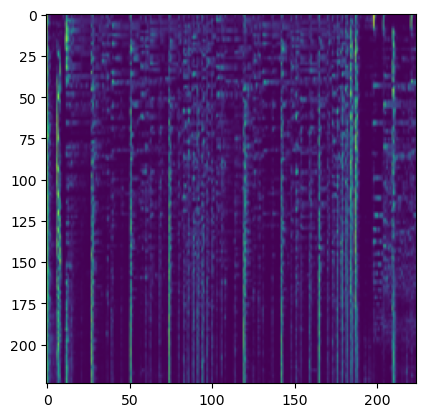

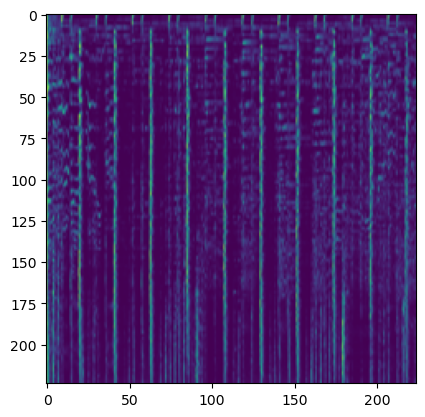

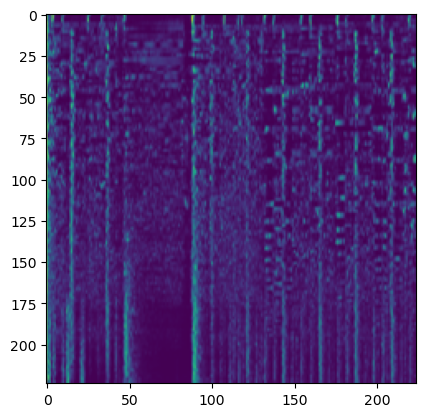

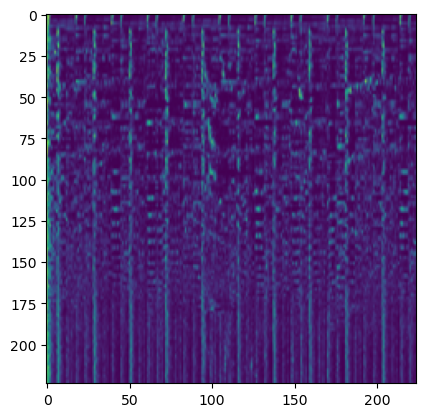

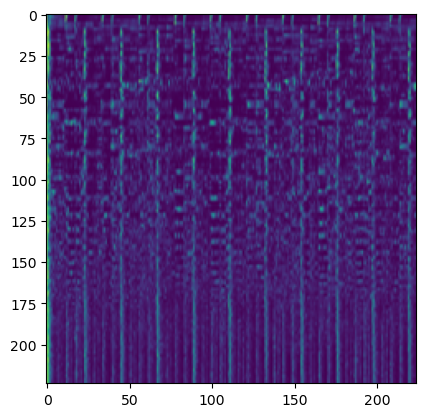

In [10]:
# Show the first few samples
inv_normalize = transforms.Normalize(
    mean=[-m/s for m, s in zip(means, sds)],
    std=[1/s for s in sds]
)

def show_image(img_tensor):
    img = inv_normalize(img_tensor)
    img = img.permute(1, 2, 0).numpy()
    plt.imshow(np.clip(img, 0, 1))
    plt.show()

for i in range(5):
    image, label = train_dataset[i]
    show_image(image)

Let's now check the dataloader. We'll start by getting one batch.

Note that the iter() function returns an interator from an iterable (like a list, tuple, or PyTorch DataLoader)

The next() function gets the next item from an iterator

In [12]:
images, labels = next(iter(train_dataloader))
print(f"Image batch shape from train: {images.shape}")
print(f"Label batch shape from train: {labels.shape}")

Image batch shape from train: torch.Size([100, 3, 224, 224])
Label batch shape from train: torch.Size([100])


Check for errors while iterating.

We'll loop through a few batches to catch any file loading or transformation errors.

Note that train_dataloader is going to... re-create the batches each time it is called, so if you re-run the next code chunk the tensor labels will change

In [32]:
for i, (imgs, lbls) in enumerate(train_dataloader):
    print(f"Batch {i}: {imgs.shape}, {lbls}")
    if i == 2:  # only check the first 3 batches
        break

Batch 0: torch.Size([100, 3, 224, 224]), tensor([125,  35, 214,   3, 227,  45,  91,  24, 100, 236,  71,  50, 115,  22,
         25,  58, 210, 206, 171,  63, 154,  14, 138, 122, 243, 213,  94, 136,
        151,  47, 189, 179,  90, 202, 113, 181,  48,  13, 197, 131, 127, 197,
        165,  86, 107,  70, 210,  72, 119, 237, 170,  65,  92,  23,  89, 171,
        175, 118, 195,  38, 132, 179, 169, 217, 107, 172,  42, 149, 220, 104,
          4, 213,  18, 171,   9, 235, 122,  23, 209,  76, 238, 213, 174, 166,
        120, 211, 197,  18,  42,  42, 197, 206, 169, 173, 157, 132, 137, 154,
        166,  15])
Batch 1: torch.Size([100, 3, 224, 224]), tensor([121, 168,  38, 221, 227, 192, 124, 237, 102, 226, 178, 107, 167, 203,
        125, 209,   6,  40,  54, 142, 126, 136, 212, 234,  45, 214, 161, 170,
        105, 152, 142, 104, 193,  56,  95, 221, 221, 214,  84,  55, 103,  33,
         46, 198,  75, 145, 167, 134,  57, 120, 219, 140,   3,  21, 180, 107,
        247,  37, 156, 134, 107, 217, 153

<h2>Loading the Model</h2>

We'll load the ResNET50 model with pretrained weights and move it to the GPU.

We can examine the individual layers. There is a full description here: https://towardsdatascience.com/the-annotated-resnet-50-a6c536034758/

The layers appear to be:
* model_resnet.layer4 (closest to output)
* model_resnet.layer3
* model_resnet.layer2
* model_resnet.layer1 (closest to input)

In [9]:
device = torch.device("mps" if torch.mps.is_available() else "cpu")
model_resnet = torchvision.models.resnet50(weights='IMAGENET1K_V2')
model_resnet = model_resnet.to(device)

In [29]:
# List the layers of resnet50
for name, layer in model_resnet.named_children():
    print(name, layer)

conv1 Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
bn1 BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
relu ReLU(inplace=True)
maxpool MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
layer1 Sequential(
  (0): Bottleneck(
    (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (downsample): Sequential(
      (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05

<h3>Link to Musicmap Genres</h3>

We'll replace the final layer in the resnet model with one that has output dimension equal to the number of genres in musicmap

In [10]:
num_classes = len(train_dataloader.dataset.classes)                     # Assuming you have train_dataloader already defined; could also set this manually

# If we don't need dropout, we can define the fc layer here:
#model_resnet.fc = nn.Linear(model_resnet.fc.in_features, num_classes).to(device)   # fc is the name of the final layer; move this to MPS

# If we want to use dropout to reduce overfitting, we can add it to fc here:
model_resnet.fc = nn.Sequential(
    nn.Dropout(p=0.2),
    nn.Linear(model_resnet.fc.in_features, num_classes)
).to(device)

# Next, make sure only fc is unfrozen
# Start by freezing all the layers
for param in model_resnet.parameters():
    param.requires_grad = False

# Unfreeze only the final classification head
for param in model_resnet.fc.parameters():
    param.requires_grad = True

<h3>Criterion</h3>

Set the criterion to our soft loss function

In [23]:
#Here I'll try to define the soft labeling for a given shortest_paths tensor, following the Bertinetto paper. This is like cross-entropy,
#but rather than just including a term for the actual label for a given input, we include weighted terms for all labels,
#where the weights are determined by proximity to the true weight in the shortest_paths tensor.

def batch_soft_labeling_loss(log_probs, targets, shortest_paths, beta):
    """
    Args:
        probs (Tensor): [batch_size, num_classes] predicted probabilities
        targets (Tensor): [batch_size] true class indices
        shortest_paths (Tensor): [num_classes, num_classes] class distance matrix
        beta (float): Softness parameter

    Returns:
        Tensor: scalar loss (mean over batch)
    """
    batch_size, num_classes = log_probs.shape

    # Create weight matrix: [batch_size, num_classes]
    #distances = shortest_paths[targets]                             # [batch_size, num_classes]
    distances = shortest_paths.to(targets.device)[targets]          # Need to move these distances to the GPU
    weights = torch.exp(-beta * distances)                          # [batch_size, num_classes]
    weights = weights / weights.sum(dim=1, keepdim=True)         # Normalize rows


    # Cross-entropy with soft labels
    loss = -torch.sum(weights * log_probs, dim=1)                  # [batch_size]
    return loss.mean()                                             # scalar


In [15]:
# Set the hyperparameter of beta
beta = 5

In [26]:
criterion_resnet = lambda outputs, labels: batch_soft_labeling_loss(outputs, labels, shortest_graph, beta)
#criterion_resnet = nn.CrossEntropyLoss()

# Could use label smoothing to prevent overconfidence during training
# 0.05 is "mild" smoothing
#criterion_resnet = nn.CrossEntropyLoss(label_smoothing=0.05)

<h2>Fine-Tuning</h2>

A general description of the process is here: https://medium.com/@caterine/fine-tuning-a-model-using-pytorch-part-2-e86a548ac4fb

To do fine-tuning, we'll start by defining the optimizer only for the final (unfrozen) layer

In [17]:
optimizer_resnet = optim.Adam(model_resnet.fc.parameters(), lr=0.001)

Next, a helper function for doing the progressive unfreezing

In [18]:
# A function to unfreeze layers by name
def unfreeze_layers_by_name(model, layer_names):
    for name, module in model.named_children():
        #print("Model child name:", name)
        if name in layer_names:
            print(f"Unfreezing layer: {name}")
            for param in module.parameters():
                param.requires_grad = True



A helper function for computing top k accuracy

In [19]:
# A version revised to be idiomatic to pytorch
def top_k_accuracy(output, target, k=3):
    with torch.no_grad():
        _, pred = output.topk(k, dim=1)
        return (pred == target.unsqueeze(1)).any(dim=1).float().mean().item()

Set the number of epochs and "cutpoints" for the unfreezing

Note that unfreezing layers too early could contribute to overfitting

In [20]:
num_epochs = 12

# Keys are epoch numbers, values are tuples: (list_of_layers_to_unfreeze, new_learning_rate)
unfreeze_schedule = {
    0: (['fc'], 1e-3),
    5: (['layer4'], 1e-4),
    10: (['layer3'], 1e-5),
    15: (['layer2'], 1e-5),
}

Since evaluation currently involves a lot of metrics, we'll set it up as a separate function that can be called within each epoch.

In [32]:
# Evaluation function
# It takes the model, dataloader, criterion, device, shortest_graph, and epoch as inputs
# and returns a dictionary with evaluation metrics
# Note that this requires idx_to_supergenre array to have been defined in the training code
def evaluate(model, dataloader, criterion, device, shortest_graph, epoch=None):
    model.eval()
    val_loss, correct, total = 0.0, 0, 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            outputs = torch.log_softmax(outputs, dim=1)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            all_preds.append(outputs)
            all_labels.append(labels)


    # Combine all predictions and labels
    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)

    val_accuracy = correct / total
    avg_val_loss = val_loss / len(dataloader)

    # Move to CPU
    pred_classes = all_preds.argmax(dim=1).cpu()
    true_classes = all_labels.cpu()

    pred_classes_np = pred_classes.numpy()
    true_classes_np = true_classes.numpy()
    
    # Extract distances and compute mean (may include inf values)
    distances = shortest_graph[pred_classes, true_classes]
    mean_shortest_distance = distances.float().mean().item()

    # Supergenre metrics
    pred_super = idx_to_supergenre[pred_classes_np]
    true_super = idx_to_supergenre[true_classes_np]
    supergenre_accuracy = np.mean(pred_super == true_super)

    # Top-3 supergenre accuracy
    top3_indices = torch.topk(all_preds, k=3, dim=1).indices.cpu().numpy()
    top3_supergenre_hits = sum(true_super[i] in idx_to_supergenre[top3] for i, top3 in enumerate(top3_indices))
    supergenre_top3_accuracy = top3_supergenre_hits / len(true_super)

    # Standard classification metrics
    precision = precision_score(true_classes_np, pred_classes_np, average='macro', zero_division=0)
    recall = recall_score(true_classes_np, pred_classes_np, average='macro', zero_division=0)
    f1 = f1_score(true_classes_np, pred_classes_np, average='macro', zero_division=0)

    # Top-k accuracies
    top3_acc = top_k_accuracy(all_preds, all_labels, k=3)
    top5_acc = top_k_accuracy(all_preds, all_labels, k=5)

    # Save confusion matrix
    cm = confusion_matrix(true_classes_np, pred_classes_np)
    class_names = train_dataset.classes  # or provide manually if needed
    cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)
    cm_df.to_csv("confusion_matrix.csv")

    # Return all metrics as a dictionary
    return {
        "val_loss": avg_val_loss,
        "val_accuracy": val_accuracy,
        "top3_accuracy": top3_acc,
        "top5_accuracy": top5_acc,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "mean_distance": mean_shortest_distance,
        "supergenre_accuracy": supergenre_accuracy,
        "supergenre_top3_accuracy": supergenre_top3_accuracy
    }

In [33]:
# Create index-to-supergenre lookup once
idx_to_supergenre = np.array([cls[:3] for cls in train_dataset.classes])  # shape (num_classes,)

# Metric lists
val_accuracy_list = []
top3_acc_list = []
top5_acc_list = []
precision_list = []
recall_list = []
f1_list = []
mean_dist_list = []
super_acc_list = []
super_top3_acc_list = []
train_loss_list = []
train_accuracy_list = []
val_loss_list = []

# === Training Loop ===
for epoch in range(num_epochs):
    if epoch in unfreeze_schedule:
        layers_to_unfreeze, lr = unfreeze_schedule[epoch]
        unfreeze_layers_by_name(model_resnet, layers_to_unfreeze)
        optimizer_resnet = torch.optim.Adam(
            filter(lambda p: p.requires_grad, model_resnet.parameters()),
            lr=lr
        )

    # --- Training ---
    model_resnet.train()
    train_loss, correct, total = 0.0, 0, 0

    for inputs, labels in tqdm.tqdm(train_dataloader, desc=f"Epoch {epoch+1} - Training", leave=False):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer_resnet.zero_grad()
        outputs = model_resnet(inputs)
# Adjust this for soft labeling
#        loss = batch_soft_labeling_loss(outputs, labels, shortest_graph, beta)

        # Take the log softmax of outputs
        outputs = torch.log_softmax(outputs, dim=1)
        loss = criterion_resnet(outputs, labels)
        loss.backward()
        optimizer_resnet.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)

    avg_train_loss = train_loss / len(train_dataloader)
    train_accuracy = correct / total

    # --- Validation ---
    metrics = evaluate(model_resnet, val_dataloader, criterion_resnet, device, shortest_graph, epoch=epoch)

    # Append metrics to lists
    for lst, key in zip(
        [val_loss_list, val_accuracy_list, top3_acc_list, top5_acc_list, precision_list, recall_list, f1_list,
        mean_dist_list, super_acc_list, super_top3_acc_list],
        ["val_loss", "val_accuracy", "top3_accuracy", "top5_accuracy", "precision", "recall", "f1",
        "mean_distance", "supergenre_accuracy", "supergenre_top3_accuracy"]
    ):
        lst.append(metrics[key])

    # Print metrics table
    headers = ["Epoch", "Train Loss", "Train Acc", "Val Loss", "Val Acc",
               "Top-3 Acc", "Top-5 Acc", "Precision", "Recall", "F1",
               "Supergenre Acc", "Top-3 Super", "Mean Dist"]

    row = [epoch + 1,
        f"{avg_train_loss:.4f}", f"{train_accuracy:.2%}",
        f"{metrics['val_loss']:.4f}", f"{metrics['val_accuracy']:.2%}",
        f"{metrics['top3_accuracy']:.2%}", f"{metrics['top5_accuracy']:.2%}",
        f"{metrics['precision']:.2%}", f"{metrics['recall']:.2%}", f"{metrics['f1']:.2%}",
        f"{metrics['supergenre_accuracy']:.2%}", f"{metrics['supergenre_top3_accuracy']:.2%}",
        f"{metrics['mean_distance']:.4f}"]

    print(tabulate([row], headers=headers, tablefmt="grid"))

Unfreezing layer: fc


+---------+--------------+-------------+------------+-----------+-------------+-------------+-------------+----------+-------+------------------+---------------+-------------+
|   Epoch |   Train Loss | Train Acc   |   Val Loss | Val Acc   | Top-3 Acc   | Top-5 Acc   | Precision   | Recall   | F1    | Supergenre Acc   | Top-3 Super   |   Mean Dist |
+=========+==============+=============+============+===========+=============+=============+=============+==========+=======+==================+===============+=============+
|       1 |       4.3251 | 17.30%      |      4.767 | 5.09%     | 12.74%      | 18.26%      | 3.16%       | 4.21%    | 2.81% | 18.67%           | 38.61%        |      3.5985 |
+---------+--------------+-------------+------------+-----------+-------------+-------------+-------------+----------+-------+------------------+---------------+-------------+


+---------+--------------+-------------+------------+-----------+-------------+-------------+-------------+----------+-------+------------------+---------------+-------------+
|   Epoch |   Train Loss | Train Acc   |   Val Loss | Val Acc   | Top-3 Acc   | Top-5 Acc   | Precision   | Recall   | F1    | Supergenre Acc   | Top-3 Super   |   Mean Dist |
+=========+==============+=============+============+===========+=============+=============+=============+==========+=======+==================+===============+=============+
|       2 |       3.7889 | 26.90%      |     4.7195 | 5.39%     | 14.00%      | 19.78%      | 3.52%       | 4.50%    | 3.30% | 19.01%           | 39.13%        |      3.5489 |
+---------+--------------+-------------+------------+-----------+-------------+-------------+-------------+----------+-------+------------------+---------------+-------------+


+---------+--------------+-------------+------------+-----------+-------------+-------------+-------------+----------+-------+------------------+---------------+-------------+
|   Epoch |   Train Loss | Train Acc   |   Val Loss | Val Acc   | Top-3 Acc   | Top-5 Acc   | Precision   | Recall   | F1    | Supergenre Acc   | Top-3 Super   |   Mean Dist |
+=========+==============+=============+============+===========+=============+=============+=============+==========+=======+==================+===============+=============+
|       3 |       3.4122 | 35.17%      |     4.7085 | 6.16%     | 14.56%      | 20.48%      | 4.78%       | 5.50%    | 4.35% | 20.57%           | 41.54%        |      3.4655 |
+---------+--------------+-------------+------------+-----------+-------------+-------------+-------------+----------+-------+------------------+---------------+-------------+


+---------+--------------+-------------+------------+-----------+-------------+-------------+-------------+----------+-------+------------------+---------------+-------------+
|   Epoch |   Train Loss | Train Acc   |   Val Loss | Val Acc   | Top-3 Acc   | Top-5 Acc   | Precision   | Recall   | F1    | Supergenre Acc   | Top-3 Super   |   Mean Dist |
+=========+==============+=============+============+===========+=============+=============+=============+==========+=======+==================+===============+=============+
|       4 |       3.0968 | 42.31%      |     4.7217 | 5.97%     | 13.90%      | 19.67%      | 5.35%       | 5.24%    | 4.55% | 19.29%           | 40.43%        |      3.5176 |
+---------+--------------+-------------+------------+-----------+-------------+-------------+-------------+----------+-------+------------------+---------------+-------------+


+---------+--------------+-------------+------------+-----------+-------------+-------------+-------------+----------+-------+------------------+---------------+-------------+
|   Epoch |   Train Loss | Train Acc   |   Val Loss | Val Acc   | Top-3 Acc   | Top-5 Acc   | Precision   | Recall   | F1    | Supergenre Acc   | Top-3 Super   |   Mean Dist |
+=========+==============+=============+============+===========+=============+=============+=============+==========+=======+==================+===============+=============+
|       5 |       2.8355 | 48.34%      |     4.7487 | 6.03%     | 13.75%      | 19.99%      | 5.12%       | 5.74%    | 4.87% | 20.80%           | 40.88%        |      3.4655 |
+---------+--------------+-------------+------------+-----------+-------------+-------------+-------------+----------+-------+------------------+---------------+-------------+
Unfreezing layer: layer4


+---------+--------------+-------------+------------+-----------+-------------+-------------+-------------+----------+-------+------------------+---------------+-------------+
|   Epoch |   Train Loss | Train Acc   |   Val Loss | Val Acc   | Top-3 Acc   | Top-5 Acc   | Precision   | Recall   | F1    | Supergenre Acc   | Top-3 Super   |   Mean Dist |
+=========+==============+=============+============+===========+=============+=============+=============+==========+=======+==================+===============+=============+
|       6 |       2.0922 | 58.09%      |     4.9395 | 7.91%     | 17.17%      | 23.88%      | 6.67%       | 7.25%    | 6.70% | 23.84%           | 45.52%        |      3.2504 |
+---------+--------------+-------------+------------+-----------+-------------+-------------+-------------+----------+-------+------------------+---------------+-------------+


+---------+--------------+-------------+------------+-----------+-------------+-------------+-------------+----------+-------+------------------+---------------+-------------+
|   Epoch |   Train Loss | Train Acc   |   Val Loss | Val Acc   | Top-3 Acc   | Top-5 Acc   | Precision   | Recall   | F1    | Supergenre Acc   | Top-3 Super   |   Mean Dist |
+=========+==============+=============+============+===========+=============+=============+=============+==========+=======+==================+===============+=============+
|       7 |       1.2835 | 77.69%      |     5.1039 | 8.00%     | 17.25%      | 24.12%      | 7.57%       | 7.60%    | 7.16% | 23.97%           | 46.31%        |       3.223 |
+---------+--------------+-------------+------------+-----------+-------------+-------------+-------------+----------+-------+------------------+---------------+-------------+


+---------+--------------+-------------+------------+-----------+-------------+-------------+-------------+----------+-------+------------------+---------------+-------------+
|   Epoch |   Train Loss | Train Acc   |   Val Loss | Val Acc   | Top-3 Acc   | Top-5 Acc   | Precision   | Recall   | F1    | Supergenre Acc   | Top-3 Super   |   Mean Dist |
+=========+==============+=============+============+===========+=============+=============+=============+==========+=======+==================+===============+=============+
|       8 |       0.8134 | 90.45%      |     5.1614 | 8.23%     | 17.55%      | 24.16%      | 7.15%       | 7.81%    | 7.14% | 24.57%           | 46.78%        |      3.2388 |
+---------+--------------+-------------+------------+-----------+-------------+-------------+-------------+----------+-------+------------------+---------------+-------------+


+---------+--------------+-------------+------------+-----------+-------------+-------------+-------------+----------+-------+------------------+---------------+-------------+
|   Epoch |   Train Loss | Train Acc   |   Val Loss | Val Acc   | Top-3 Acc   | Top-5 Acc   | Precision   | Recall   | F1    | Supergenre Acc   | Top-3 Super   |   Mean Dist |
+=========+==============+=============+============+===========+=============+=============+=============+==========+=======+==================+===============+=============+
|       9 |       0.5425 | 96.63%      |     5.2779 | 8.06%     | 16.83%      | 23.73%      | 7.43%       | 7.78%    | 7.30% | 24.87%           | 46.40%        |      3.1971 |
+---------+--------------+-------------+------------+-----------+-------------+-------------+-------------+----------+-------+------------------+---------------+-------------+


+---------+--------------+-------------+------------+-----------+-------------+-------------+-------------+----------+-------+------------------+---------------+-------------+
|   Epoch |   Train Loss | Train Acc   |   Val Loss | Val Acc   | Top-3 Acc   | Top-5 Acc   | Precision   | Recall   | F1    | Supergenre Acc   | Top-3 Super   |   Mean Dist |
+=========+==============+=============+============+===========+=============+=============+=============+==========+=======+==================+===============+=============+
|      10 |       0.4013 | 99.05%      |     5.3591 | 7.72%     | 17.15%      | 24.20%      | 7.17%       | 7.41%    | 6.97% | 24.22%           | 46.78%        |      3.2085 |
+---------+--------------+-------------+------------+-----------+-------------+-------------+-------------+----------+-------+------------------+---------------+-------------+
Unfreezing layer: layer3


+---------+--------------+-------------+------------+-----------+-------------+-------------+-------------+----------+-------+------------------+---------------+-------------+
|   Epoch |   Train Loss | Train Acc   |   Val Loss | Val Acc   | Top-3 Acc   | Top-5 Acc   | Precision   | Recall   | F1    | Supergenre Acc   | Top-3 Super   |   Mean Dist |
+=========+==============+=============+============+===========+=============+=============+=============+==========+=======+==================+===============+=============+
|      11 |       0.3392 | 99.61%      |     5.3707 | 7.53%     | 17.21%      | 24.33%      | 6.96%       | 7.17%    | 6.80% | 24.87%           | 46.10%        |       3.208 |
+---------+--------------+-------------+------------+-----------+-------------+-------------+-------------+----------+-------+------------------+---------------+-------------+


+---------+--------------+-------------+------------+-----------+-------------+-------------+-------------+----------+-------+------------------+---------------+-------------+
|   Epoch |   Train Loss | Train Acc   |   Val Loss | Val Acc   | Top-3 Acc   | Top-5 Acc   | Precision   | Recall   | F1    | Supergenre Acc   | Top-3 Super   |   Mean Dist |
+=========+==============+=============+============+===========+=============+=============+=============+==========+=======+==================+===============+=============+
|      12 |       0.3163 | 99.77%      |     5.3316 | 8.06%     | 17.58%      | 24.91%      | 7.42%       | 7.68%    | 7.24% | 25.70%           | 46.31%        |      3.1758 |
+---------+--------------+-------------+------------+-----------+-------------+-------------+-------------+----------+-------+------------------+---------------+-------------+


Next we'll do the plotting

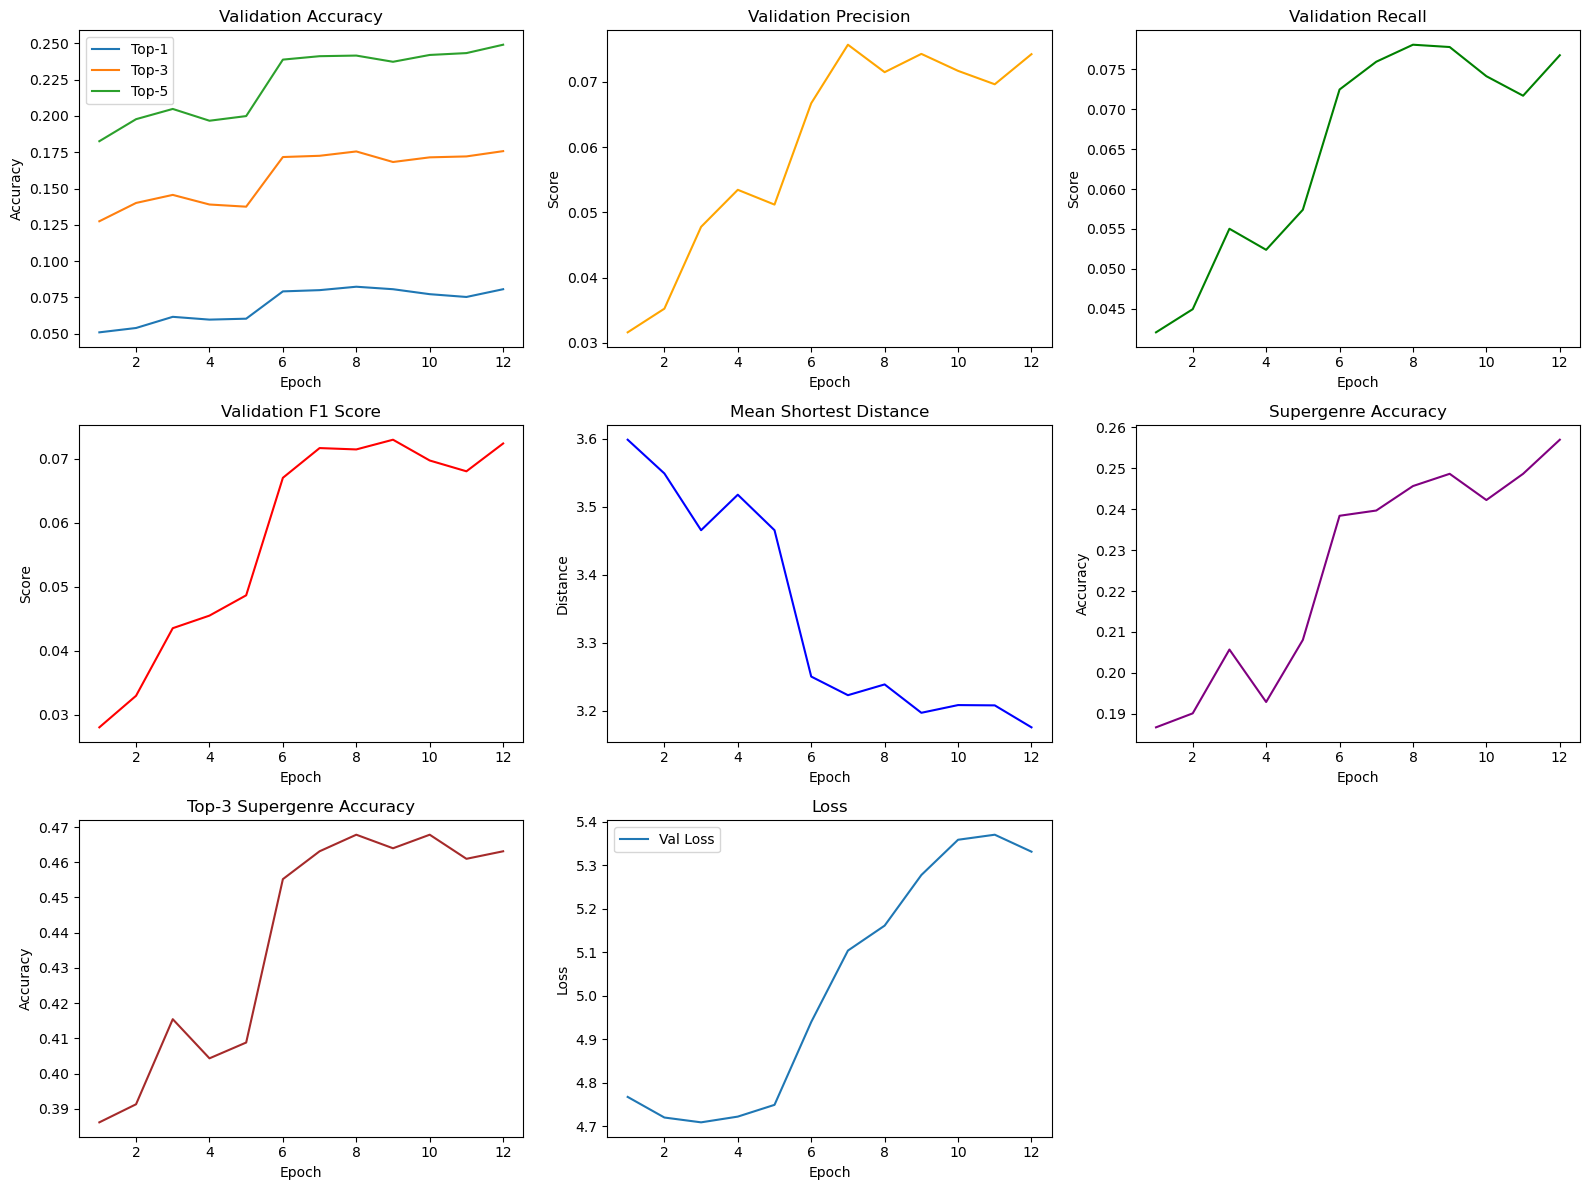

In [34]:

epochs = range(1, num_epochs + 1)

plt.figure(figsize=(16, 12))

# Validation Accuracy
plt.subplot(3, 3, 1)
plt.plot(epochs, val_accuracy_list, label='Top-1')
plt.plot(epochs, top3_acc_list, label='Top-3')
plt.plot(epochs, top5_acc_list, label='Top-5')
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Precision
plt.subplot(3, 3, 2)
plt.plot(epochs, precision_list, label='Precision', color='orange')
plt.title('Validation Precision')
plt.xlabel('Epoch')
plt.ylabel('Score')

# Recall
plt.subplot(3, 3, 3)
plt.plot(epochs, recall_list, label='Recall', color='green')
plt.title('Validation Recall')
plt.xlabel('Epoch')
plt.ylabel('Score')

# F1 Score
plt.subplot(3, 3, 4)
plt.plot(epochs, f1_list, label='F1 Score', color='red')
plt.title('Validation F1 Score')
plt.xlabel('Epoch')
plt.ylabel('Score')

# Mean Shortest Distance
plt.subplot(3, 3, 5)
plt.plot(epochs, mean_dist_list, label='Mean Shortest Distance', color='blue')
plt.title('Mean Shortest Distance')
plt.xlabel('Epoch')
plt.ylabel('Distance')

# Supergenre Accuracy
plt.subplot(3, 3, 6)
plt.plot(epochs, super_acc_list, label='Supergenre Accuracy', color='purple')
plt.title('Supergenre Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

# Top-3 Supergenre Accuracy
plt.subplot(3, 3, 7)
plt.plot(epochs, super_top3_acc_list, label='Top-3 Supergenre Accuracy', color='brown')
plt.title('Top-3 Supergenre Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

# Train and Val Loss
plt.subplot(3, 3, 8)
#plt.plot(epochs, train_loss_list, label='Train Loss')
plt.plot(epochs, val_loss_list, label='Val Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Train Accuracy
#plt.subplot(3, 3, 9)
#plt.plot(epochs, train_accuracy_list, label='Train Accuracy', color='cyan')
#plt.title('Train Accuracy')
#plt.xlabel('Epoch')
#plt.ylabel('Accuracy')

plt.tight_layout()
plt.show()

If things look good, we can save the weights

In [35]:
torch.save(model_resnet.state_dict(), 'resnet_15sec_augmented_softlabel.pth')

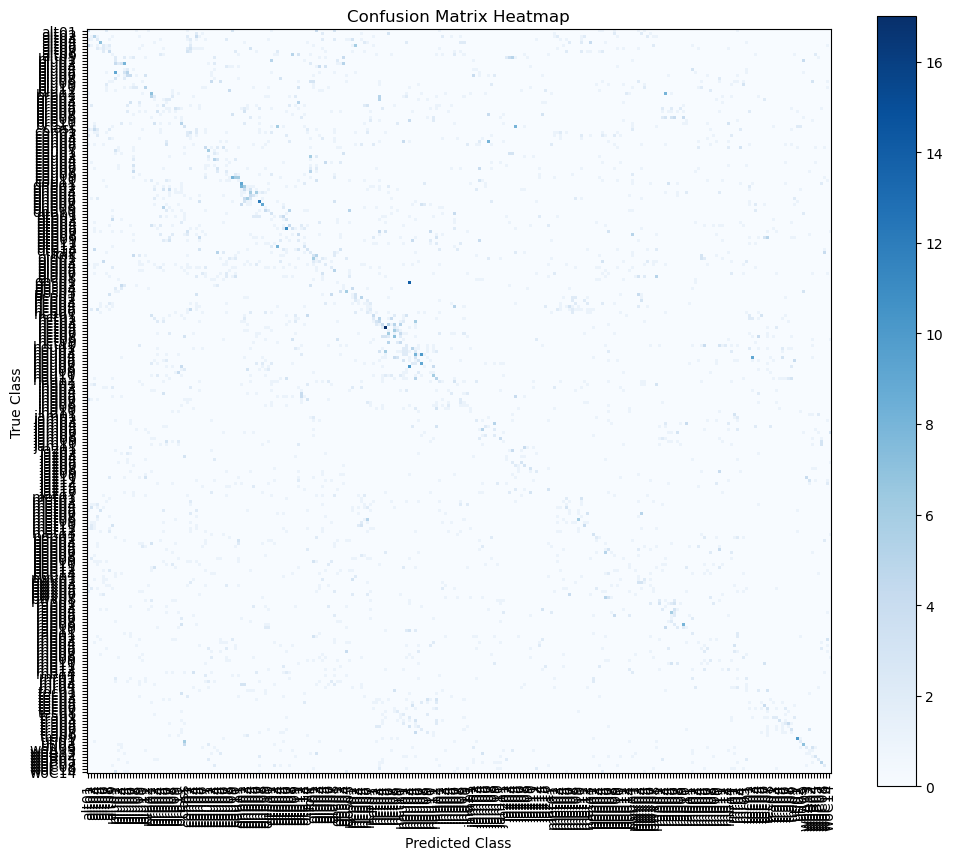

In [37]:
# Load confusion_matrix.csv and make a heatmap of the confusion matrix
confusion_df = pd.read_csv("confusion_matrix.csv", index_col=0)
plt.figure(figsize=(12, 10))
plt.imshow(confusion_df, cmap='Blues', interpolation='nearest')
plt.colorbar()
plt.xticks(ticks=np.arange(len(confusion_df.columns)), labels=confusion_df.columns, rotation=90)
plt.yticks(ticks=np.arange(len(confusion_df.index)), labels=confusion_df.index)
plt.title("Confusion Matrix Heatmap")
plt.xlabel("Predicted Class")
plt.ylabel("True Class")

# Save as a png file
plt.savefig("confusion_matrix_heatmap.png")